# Import Libraries and dataset

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    cross_val_predict, cross_validate,
    TunedThresholdClassifierCV,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, roc_curve, make_scorer,
    RocCurveDisplay, ConfusionMatrixDisplay
)

In [ ]:
url = 'https://drive.google.com/file/d/1w2bQfN6WMUnSK39vSwyqpWpGnhZZdopN/view?usp=drive_link'
path = path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

train_data = pd.read_csv(path).set_index('Id')

train_data.head()

,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population,poisonous
Id,,,,,,,
6573,k,e,False,w,w,v,1
4426,f,e,True,p,w,y,0
7018,b,w,False,w,w,s,0
5789,k,g,False,w,w,n,0
6187,f,n,True,p,g,v,0


I will separate the dataset into features and labels, then splits the data into training and testing sets.
First, I will creates a copy of the training data and removes the poisonous column to use as the target variable (y), leaving the remaining columns as input features (X).
Then use the train_test_split to divide the data into training (80%) and testing (20%) subsets with a fixed random seed for reproducibility.

In [ ]:
X = train_data.copy()
y = X.pop('poisonous')

X

,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population
Id,,,,,,
6573,k,e,False,w,w,v
4426,f,e,True,p,w,y
7018,b,w,False,w,w,s
5789,k,g,False,w,w,n
6187,f,n,True,p,g,v
...,...,...,...,...,...,...
7002,f,g,False,b,b,v
7323,k,e,False,p,p,v
6206,f,g,False,n,b,y


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

I will build a machine learning classification pipeline to predict whether a mushroom is poisonous. After loading the dataset and preparing the training and testing splits, I will create a Scikit-learn pipeline that handles missing values, encodes categorical features, and trains a Gradient Boosting classifier. I will then use GridSearchCV to compare different encoding strategies and tune key model hyperparameters using ROC-AUC as the evaluation metric. Finally, I will evaluate model performance using cross-validated probability predictions and visualize the results with an ROC curve.

In [20]:
url = 'https://drive.google.com/file/d/1b3jRru18eq0_Gwvm3r652eQEv2I6Sl8r/view?usp=sharing'
path = path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

test_data = pd.read_csv(path).set_index('Id')

test_data.head()

,cap.shape,cap.color,stalk.color.above.ring,stalk.color.below.ring,bruises,population
Id,,,,,,
5165,f,w,w,w,True,v
4281,f,g,n,p,False,v
231,x,n,w,p,True,v
3890,f,n,w,w,False,s
1521,x,y,n,p,False,v


In [ ]:
model = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder(random_state=42)),
    ('gbc', GradientBoostingClassifier(random_state=42))
])

In [ ]:
params = model.get_params()
print(params)

{'memory': None, 'steps': [('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', TargetEncoder(random_state=42)), ('gbc', GradientBoostingClassifier(random_state=42))], 'transform_input': None, 'verbose': False, 'imputer': SimpleImputer(strategy='most_frequent'), 'encoder': TargetEncoder(random_state=42), 'gbc': GradientBoostingClassifier(random_state=42), 'imputer__add_indicator': False, 'imputer__copy': True, 'imputer__fill_value': None, 'imputer__keep_empty_features': False, 'imputer__missing_values': nan, 'imputer__strategy': 'most_frequent', 'encoder__categories': 'auto', 'encoder__cv': 5, 'encoder__random_state': 42, 'encoder__shuffle': True, 'encoder__smooth': 'auto', 'encoder__target_type': 'auto', 'gbc__ccp_alpha': 0.0, 'gbc__criterion': 'friedman_mse', 'gbc__init': None, 'gbc__learning_rate': 0.1, 'gbc__loss': 'log_loss', 'gbc__max_depth': 3, 'gbc__max_features': None, 'gbc__max_leaf_nodes': None, 'gbc__min_impurity_decrease': 0.0, 'gbc__min_samples_leaf': 1, 'gbc

In [ ]:
param_grid = {
    # Trying out different encoders
    'encoder': [
        OneHotEncoder(handle_unknown='ignore'),
        TargetEncoder(random_state=42)
    ],
    # Tuning hyperparameters of GB model
    'gbc__n_estimators': range(300, 600, 50),
    'gbc__subsample': np.linspace(0.7, 1.0, 7),
}

search = GridSearchCV(
    model,
    param_grid,
    scoring='roc_auc', #recommended score to for hyperparameter tuning
    n_jobs=-2,
    verbose=2
)

search.fit(X_train, y_train)
search.best_params_

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), gbc__n_estimators=300, gbc__subsample=0.7; total time=   2.9s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), gbc__n_estimators=300, gbc__subsample=0.7; total time=   4.0s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), gbc__n_estimators=300, gbc__subsample=0.7; total time=   2.1s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), gbc__n_estimators=300, gbc__subsample=0.7; total time=   1.6s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), gbc__n_estimators=300, gbc__subsample=0.7; total time=   1.1s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), gbc__n_estimators=300, gbc__subsample=0.75; total time=   1.1s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), gbc__n_estimators=300, gbc__subsample=0.75; total time=   1.1s
[CV] END encoder=OneHotEncoder(handle_unknown='ignore'), gbc__n_estimators=300, gbc__subsample=0.75; to

{'encoder': OneHotEncoder(handle_unknown='ignore'),
 'gbc__n_estimators': 450,
 'gbc__subsample': np.float64(0.75)}

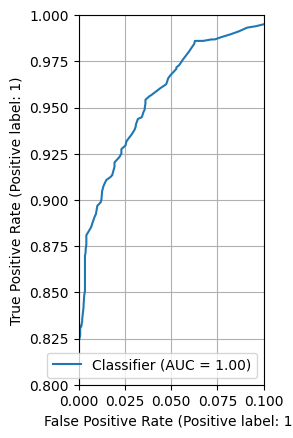

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Get probabilities with cross-validation to evaluate generalization
cv_probs = cross_val_predict(
    search.best_estimator_,
    X_train, y_train,
    method='predict_proba'
)[:, 1] #grab just probability of positive

# Display ROC curve
RocCurveDisplay.from_predictions(y_train, cv_probs)

plt.xlim(0.0, 0.1)
plt.ylim(0.8, 1.0)
plt.grid(True)
plt.figure(figsize=(12,8))
plt.show()

The ROC curve shows excellent model performance, with an AUC of 1.00, indicating near-perfect discrimination between poisonous and non-poisonous mushrooms on the training data. The curve rises steeply toward the top-left corner, meaning the model achieves a very high true positive rate while keeping false positives extremely low. This suggests that the pipeline, including preprocessing, encoding, and Gradient Boosting, is highly effective at capturing the underlying patterns in the dataset.

However, such an exceptionally high AUC may also indicate possible overfitting, especially since the evaluation is based on cross-validated predictions from the training set. Further validation on the held-out test set is important to confirm that the model generalizes well to unseen data.

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, cv_probs)

roc_df = pd.DataFrame({
    'tfr': fpr,
    'tpr': tpr,
    'Threshold': thresholds
})
roc_df

,tfr,tpr,Threshold
0,0.000000,0.000000,inf
1,0.000000,0.003586,0.999958
2,0.000000,0.005976,0.999950
3,0.000000,0.008765,0.999948
4,0.000000,0.012749,0.999939
...,...,...,...
1180,0.995165,1.000000,0.000013
1181,0.995537,1.000000,0.000013
1182,0.997769,1.000000,0.000012
1183,0.998512,1.000000,0.000010


In [ ]:
roc_df[roc_df.tpr==1].sort_values("Threshold", ascending=False).head(1)

,tfr,tpr,Threshold
550,0.1283,1.0,0.043785


I computed the ROC curve by extracting the false positive rates (FPR), true positive rates (TPR), and classification thresholds from the cross-validated probability predictions. I then stored these values in a DataFrame to make the trade-offs between sensitivity and false alarms easier to inspect numerically, rather than only visually from the ROC plot.

Next, I filtered the ROC results to identify the point where the true positive rate reaches 1.0, meaning the model correctly identifies all poisonous mushrooms. Among those points, I selected the highest probability threshold, which represents the most conservative decision rule that still achieves perfect recall.

The result shows that at a threshold of approximately 0.044, the model achieves 100% true positive rate with a false positive rate of about 12.8%. This means the model can detect every poisonous mushroom while only misclassifying around 13% of safe mushrooms as poisonous, which is a reasonable trade-off in a safety-critical context where false negatives are more costly than false positives.

In [ ]:
y_probs = search.predict_proba(X_test)[:, 1]

# Apply the custom threshold
y_pred_custom = (y_probs > 0.043785).astype(int)

I generate predicted probabilities for the test set using the best model and apply a custom decision threshold (0.043785) instead of the default 0.5. This threshold is chosen from the ROC analysis to ensure maximum recall for the positive class. I then convert the probabilities into class labels and visualize the results with a confusion matrix.

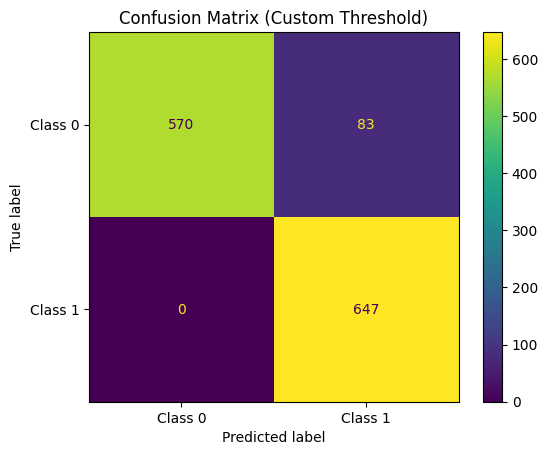

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_custom, display_labels=["Class 0", "Class 1"])
plt.title("Confusion Matrix (Custom Threshold)")
plt.show()

Confusion Matrix Analysis

The confusion matrix shows zero false negatives, meaning the model correctly identifies all Class 1 samples. This confirms that the custom threshold achieves 100% recall for the positive class. The trade-off is an increase in false positives (83 cases), where some Class 0 samples are incorrectly labeled as Class 1. This is acceptable for this problem, as prioritizing safety is more important than avoiding false alarms.

In [ ]:
def cost_balance(y_true, y_pred):
    # Define costs
    poison_cost = 55
    missed_food_cost = 1
    # Get error frequencies
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Multiply errors by their costs
    total_error = (fp * missed_food_cost) + (fn * poison_cost)
    return total_error

# Turn function into sklearn scorer
cost_balance_score = make_scorer(cost_balance, greater_is_better=False)


# Initialize threshold tuner
threshold_tuner = TunedThresholdClassifierCV(
    estimator=search.best_estimator_,
    scoring=cost_balance_score,
)
# Cross-validate threshold
cv_results = cross_validate(
    threshold_tuner,
    X_train, y_train,
    return_estimator=True
)
# Average thresholds for best generalization performance
cv_tuned_threshold = np.mean([estimator.best_threshold_ for estimator in cv_results['estimator']])
cv_tuned_threshold

**What I did in this code**

I defined a custom cost function that penalizes mistakes differently:

False negatives (FN) = predicting not poisonous when it is poisonous → cost 55 (very expensive).

False positives (FP) = predicting poisonous when it’s safe → cost 1 (small penalty).

I converted that function into an sklearn scorer so it can be used during model tuning.

I used TunedThresholdClassifierCV to learn the best probability threshold (not necessarily 0.5) that minimizes my total cost.

I cross-validated it on the training set, then took the average best threshold across folds for stability.

Finally, I applied this tuned threshold to the test set probabilities and plotted the confusion matrix.

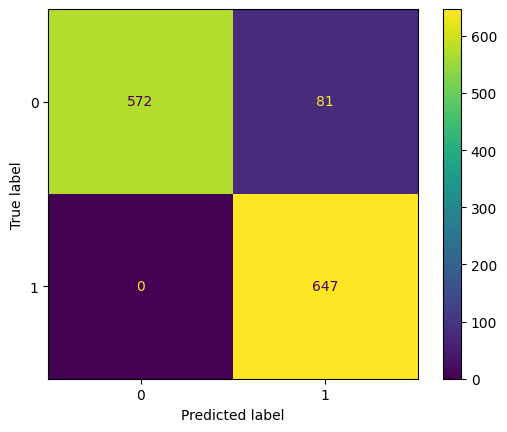

In [15]:
test_probs = search.best_estimator_.predict_proba(X_test)[:,1]
test_preds = (test_probs > cv_tuned_threshold).astype(int)

ConfusionMatrixDisplay.from_predictions(y_test, test_preds);

**Confusion Matrix result**

From the matrix:

TN = 572 (correctly predicted Class 0)

FP = 81 (safe mushrooms predicted as poisonous)

FN = 0 (poisonous mushrooms predicted as safe)

TP = 647 (correctly predicted Class 1)

Key takeaway: I achieved 0 false negatives, which is the main goal since FN carries a huge cost (55). The tuned threshold keeps safety high by catching all poisonous cases, while allowing a manageable number of false alarms (81 false positives).

In [16]:
# Fit model to full dataset
search.best_estimator_.fit(X, y)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore')),
                ('gbc',
                 GradientBoostingClassifier(n_estimators=450, random_state=42,
                                            subsample=np.float64(0.75)))])

In [17]:
X_comp = test_data[X.columns]
X_comp

,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population
Id,,,,,,
5165,f,w,True,w,w,v
4281,f,g,False,n,p,v
231,x,n,True,w,p,v
3890,f,n,False,w,w,s
1521,x,y,False,n,p,v
...,...,...,...,...,...,...
983,x,n,False,w,y,v
7055,x,e,True,p,g,v
7456,x,y,False,b,n,y


In [18]:
comp_probs = search.best_estimator_.predict_proba(X_comp)[:,1]
comp_preds = (comp_probs > cv_tuned_threshold).astype(int)

submission = pd.DataFrame(
   {"Id":X_comp.index,
    "poisonous": comp_preds}
)

submission.columns

Index(['Id', 'poisonous'], dtype='object')

In [19]:
# submission.to_csv('submission.csv', index=None)